## Sentiment Analysis

### EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # import seaborn library for plotting 
import re
%matplotlib inline
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.decomposition import NMF
# import pyLDAvis.sklearn # a specialized package for topic model visualization
from sklearn.manifold import TSNE
# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nechamaborisute/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nechamaborisute/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nechamaborisute/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Load in data already separated into train and test data
train = pd.read_csv('train.csv.zip', encoding='latin-1')
test = pd.read_csv('test.csv', encoding='latin-1')

# combine train andtest for cleaning 
data = pd.concat([train, test], axis = 0)

# Look at data information, dtypes, nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


In [6]:
# drop nulls 
data = data.dropna()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  object 
 4   Time of Tweet     27480 non-null  object 
 5   Age of User       27480 non-null  object 
 6   Country           27480 non-null  object 
 7   Population -2020  27480 non-null  float64
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.3+ MB


In [8]:
data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


### Preprocess tweet text data

In [9]:
data['text'].head(10)

0                  I`d have responded, if I were going
1        Sooo SAD I will miss you here in San Diego!!!
2                            my boss is bullying me...
3                       what interview! leave me alone
4     Sons of ****, why couldn`t they put them on t...
5    http://www.dothebouncy.com/smf - some shameles...
6    2am feedings for the baby are fun when he is a...
7                                           Soooo high
8                                          Both of you
9     Journey!? Wow... u just became cooler.  hehe....
Name: text, dtype: object

In [10]:
def process_tweet(tweet_text, min_length):
    
    # get common stop words
    stop_words = stopwords.words('english')
    
    # instantiate lemmatizer
    wnl = WordNetLemmatizer()
    
    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return tweet_norm

#### Apply text normalization and delete empty tweets

In [11]:
# apply function to tweets
data['text'] = data['text'].apply(process_tweet, args = [10])

In [12]:
# get rid of empty tweets
data_new = data[data['text'] != '']

In [13]:
data_new['text']

10       much love hopeful reckon chance minimal never ...
17           sick past day thus hair look wierd didnt look
21       play ghost online really interesting new updat...
32       consolation get bmi test hahaha say obesed wel...
34       ahhh slept game gon try best watch tomorrow ho...
                               ...                        
27446    glad co u wouldnt lose fan anyway get see guy ...
27454    see picture carl john everyone read face proud...
27458    really wish someone make groupchat theme adium...
27474    get early feel good day walk work feeling alri...
27478    yay good enjoy break probably hectic weekend t...
Name: text, Length: 4932, dtype: object

### Creating Bag of Words Term-Document Matrix

In [14]:
corpus = data_new['text']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)
X_train

<4932x10040 sparse matrix of type '<class 'numpy.float64'>'
	with 56081 stored elements in Compressed Sparse Row format>

In [16]:
len(vectorizer.get_feature_names_out())

10040

### Topic Modeling

In [17]:
topic_model = NMF(n_components = 5)
topic_model.fit(X_train)

NMF(n_components=5)

In [19]:
# to get H
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (5, 10040)
Shape of H is (4932, 5)
Shape of X_train is (4932, 10040)


The W matrix
Let's take a look at the tokens (columns of W) with highest weight for each topic (columns) in W:

In [23]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['still', 'bad', 'friend', 'ur', 'back', 'dont', 'look', 'new', 'haha', 'want', 'much', 'feel', 'miss', 'say', 'come', 'think', 'make', 'im', 'well', 'love', 'time', 'see', 'lol', 'know', 'really']


THE TOP 10 WORDS FOR TOPIC #1
['bed', 'best', 'everyone', 'make', 'present', 'war', 'family', 'star', 'gift', 'wish', 'nice', 'mum', 'tomorrow', 'enjoy', 'hope', 'wonderful', 'world', 'today', 'great', 'mommy', 'love', 'mom', 'happy', 'mother', 'day']


THE TOP 10 WORDS FOR TOPIC #2
['bad', 'tomorrow', 'hair', 'finally', 'still', 'job', 'next', 'home', 'girl', 'wait', 'school', 'try', 'hour', 'new', 'lol', 'early', 'start', 'do', 'work', 'today', 'need', 'ready', 'back', 'ta', 'get']


THE TOP 10 WORDS FOR TOPIC #3
['bore', 'party', 'rain', 'month', 'sleep', 'car', 'miss', 'head', 'wish', 'tonight', 'week', 'house', 'see', 'school', 'want', 'away', 'wan', 'gon', 'tomorrow', 'bed', 'today', 'back', 'im', 'home', 'go']


THE TOP 10 WORDS FOR TOPIC #4
['bad', 'ne

It's often helpful to make a bar visualization of the most relevant token weights for each topic.

In [25]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

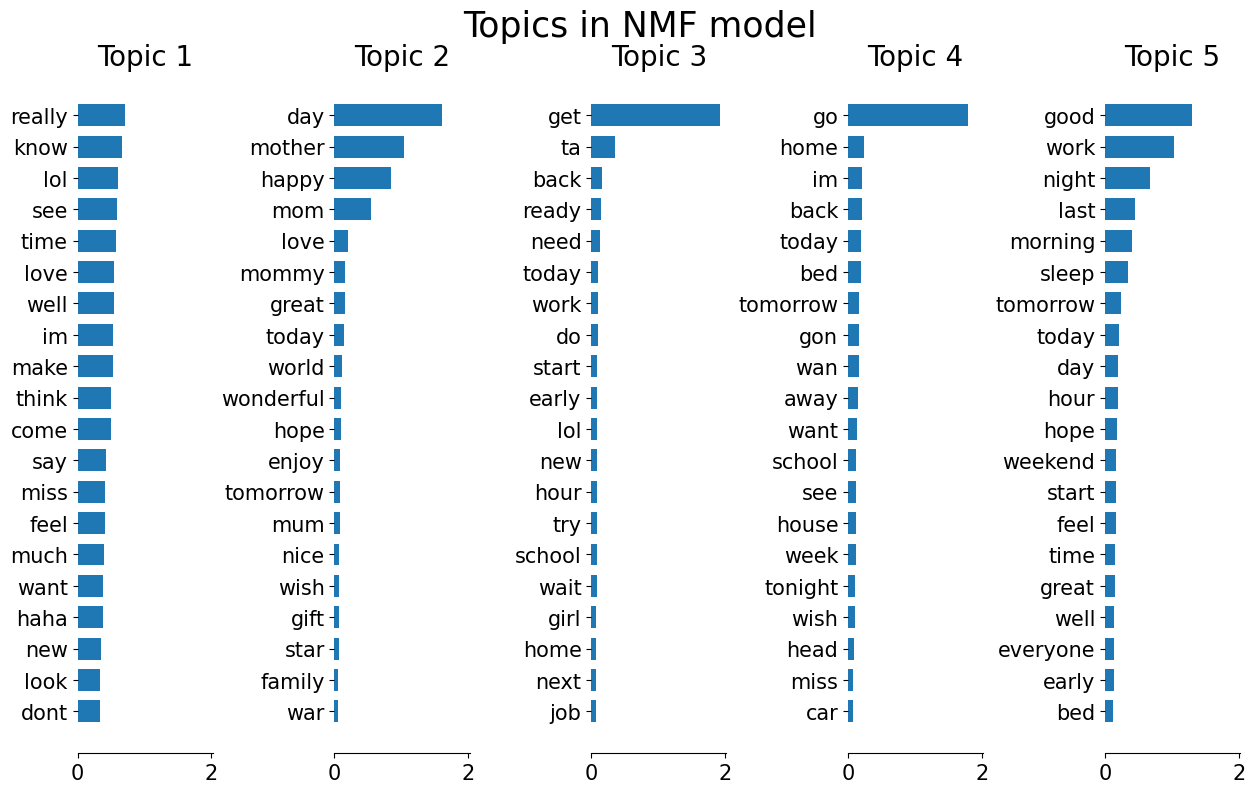

In [26]:
topic_word_plot()

In [ ]:
# vis = pyLDAvis.sklearn.prepare(topic_model, X_train, vectorizer)
# pyLDAvis.display(vis)
# pyLDAvis.save_html(vis, 'nmf_topics.html')

The H matrix contains information about breakdowns of topics in each document. Let's see this in action.

In [27]:
topic_name_dict = {0: 'the_feelings', 1: 'mothers_day', 2: 'activities', 3: 'traveling', 4: 'good_wishes'}

In [28]:
# takes in list of documents and plots topic weight vectors for each document
def tweet_topbreakdown(locator):

    print(data.loc[locator].text)
    int_index = data_new.index.get_loc(locator)

    topic_keys = topic_name_dict.values()
    zipped_tuple = list(zip(topic_keys, list(H[int_index,:])))

    topic_breakdown = pd.DataFrame(zipped_tuple, columns = ['Topic', 'Weight']).set_index(['Topic'])
    topic_breakdown['Normalized weight'] = topic_breakdown['Weight']/topic_breakdown['Weight'].sum()

    sns.barplot(y = topic_breakdown.index, x = 'Normalized weight', data = topic_breakdown)
    plt.title("Distribution of topics for tweet no. " + str(locator))
    plt.show()

    return topic_breakdown

egh blah boooooooooooo dunno wan go work hangover suckkkkkk im drunk mess


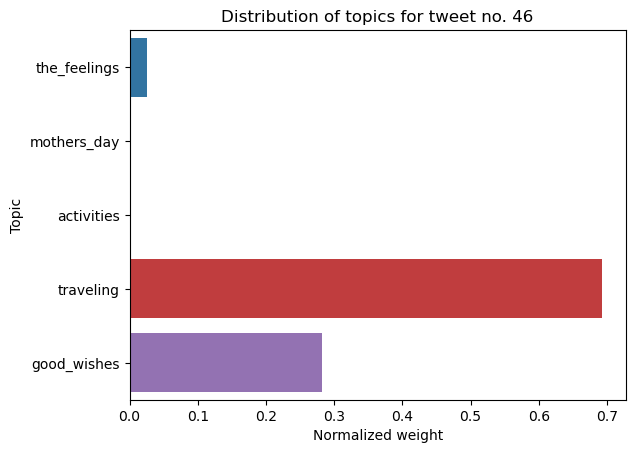

much love hopeful reckon chance minimal never gon get cake stuff


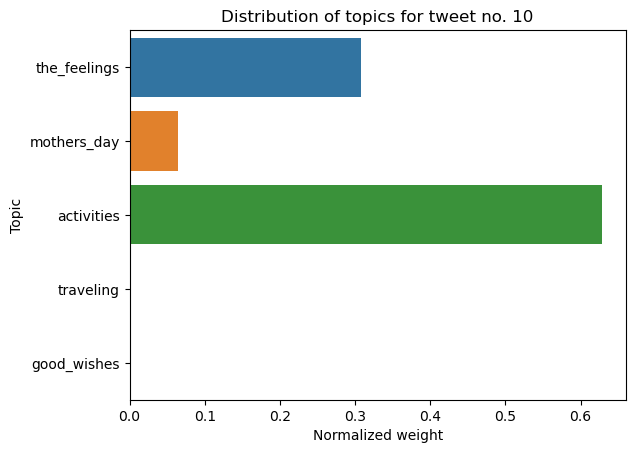

sick past day thus hair look wierd didnt look


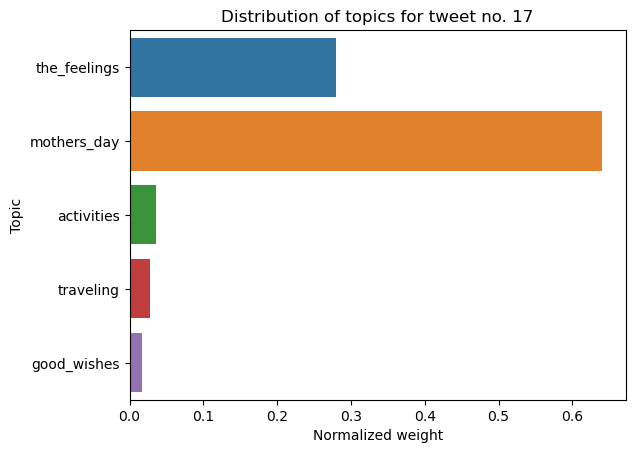

yay good enjoy break probably hectic weekend take care hun xxxx


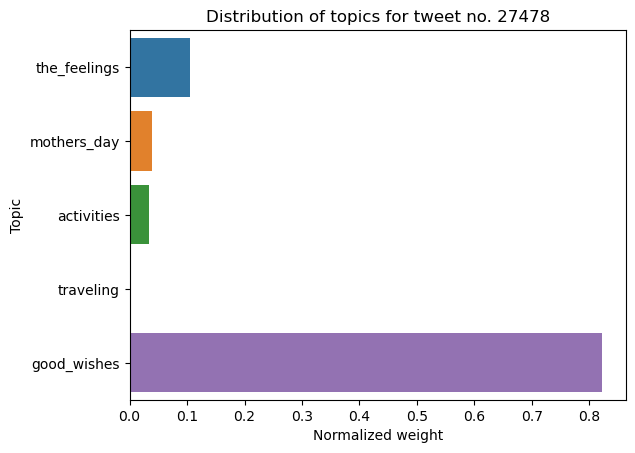

In [29]:
tweet_loc_list = [46,10,17, 27478]
g = list(map(tweet_topbreakdown, tweet_loc_list))

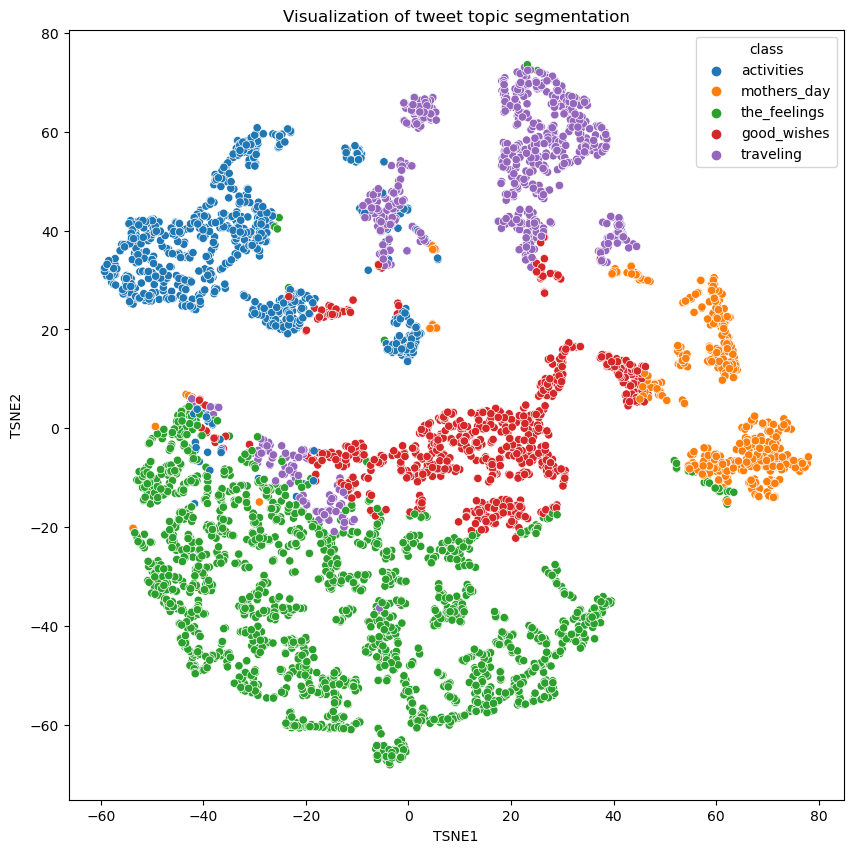

In [31]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

# for each document takes the topic with highest weight and assigns document to this class -- hard clustering.
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Visualization of tweet topic segmentation')
plt.show()

## Sentiment analysis

<AxesSubplot:xlabel='sentiment', ylabel='count'>

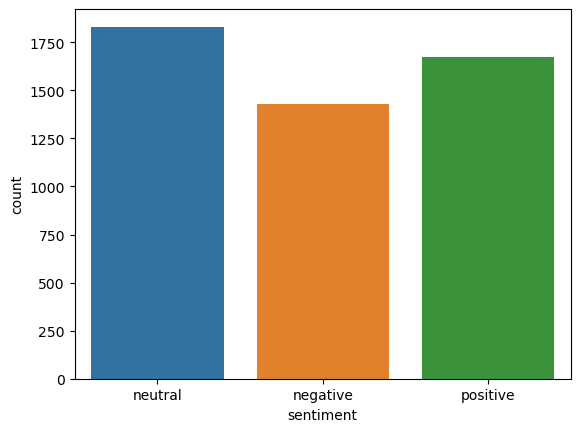

In [33]:
sns.countplot(data = data_new, x = data_new['sentiment'])

### Vectorizer

In [64]:
X = data_new['text']
y = data_new['sentiment']

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y_trans = enc.fit_transform(y)

In [65]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(X)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, y_trans, test_size=0.3, random_state=52)

### Modeling

In [76]:
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       451
           1       0.46      0.59      0.51       547
           2       0.66      0.55      0.60       482

    accuracy                           0.54      1480
   macro avg       0.56      0.54      0.54      1480
weighted avg       0.56      0.54      0.54      1480



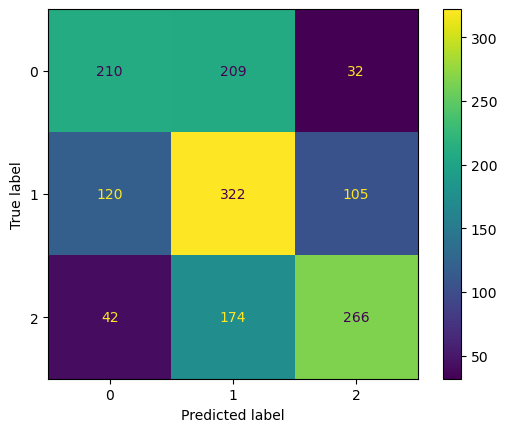

In [82]:
ConfusionMatrixDisplay.from_estimator(logreg_model, X_test, y_test)

In [75]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.51      0.50      0.50       451
           1       0.45      0.47      0.46       547
           2       0.58      0.57      0.57       482

    accuracy                           0.51      1480
   macro avg       0.51      0.51      0.51      1480
weighted avg       0.51      0.51      0.51      1480



In [72]:
from sklearn.naive_bayes import ComplementNB

compnb = ComplementNB()
compnb.fit(X_train, y_train)
y_pred_nb = compnb.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.53      0.50      0.52       451
           1       0.45      0.39      0.42       547
           2       0.54      0.66      0.59       482

    accuracy                           0.51      1480
   macro avg       0.51      0.52      0.51      1480
weighted avg       0.51      0.51      0.51      1480



In [74]:
from sklearn.naive_bayes import MultinomialNB

multinb = MultinomialNB()
multinb.fit(X_train, y_train)
y_pred_multi_nb = multinb.predict(X_test)
print(classification_report(y_test, y_pred_multi_nb))

              precision    recall  f1-score   support

           0       0.63      0.16      0.25       451
           1       0.42      0.68      0.52       547
           2       0.59      0.57      0.58       482

    accuracy                           0.49      1480
   macro avg       0.55      0.47      0.45      1480
weighted avg       0.54      0.49      0.46      1480



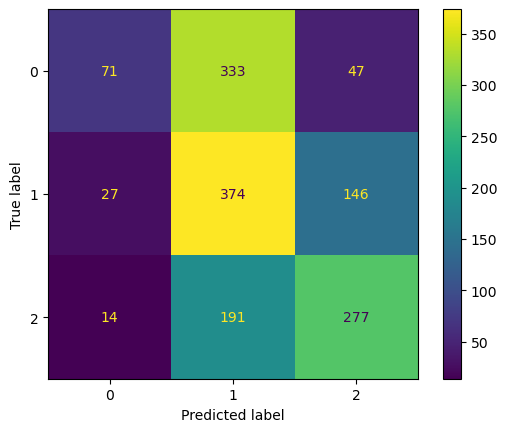

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(multinb, X_test, y_test)